In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
#pip install sentiment-analysis-spanish
from sentiment_analysis_spanish import sentiment_analysis

import re
from wordcloud import WordCloud, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize 

In [2]:
df = pd.read_csv('base_completa.csv')
df.head()

,date,tweet
0,2010-01-01,"Comienzo 2010 feliz x mi familia, gratitud Ban..."
1,2010-01-03,Uf! qué mala plataforma BancoChile para ctas. ...
2,2010-01-04,Porque la pag del Banco @bancodechile es siemp...
3,2010-01-04,algun lugar recomendable para comprar euros? @...
4,2010-01-04,Y es así como BancoChile.cl se va al suelo cua...


In [3]:
# función para normalizar letras, quitar tildes..
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s
# función para quitar menciones entre otros.
def CleanText(text):
    text = re.sub(r'@[A-Za-z0-9_]+','',text) # quitar @ mentionts
    text = re.sub(r'#','',text) # quitar # 
    text = re.sub(r'RT[\s]+','',text) # remover retweets
    text = re.sub(r'https?:\/\/\S+','',text) # remover links
    text = re.sub(r"^\s+|\s+$", "", text)
    #text = re.sub(r'_[A-Za-z0-9]+','',text) # quitar @ mentionts
    
    return text
# se limpia el texto

In [4]:
df["tweet"] = df["tweet"].str.lower()
df['tweet'] = df.apply(lambda row : normalize(row['tweet']), axis = 1)
df['tweet'] = df['tweet'].apply(CleanText) 

In [5]:
stop_words = set(stopwords.words('spanish'))
stop_words.update(['banco','bancoestado','estado','(',')',' " ','q','chile','ahora','si','..','.','...',':'
                  ,',','hola','?',']','[', 'bancochile','bancodechile','bci','pato'])

**WordCloud para todos los tweets recopilados**

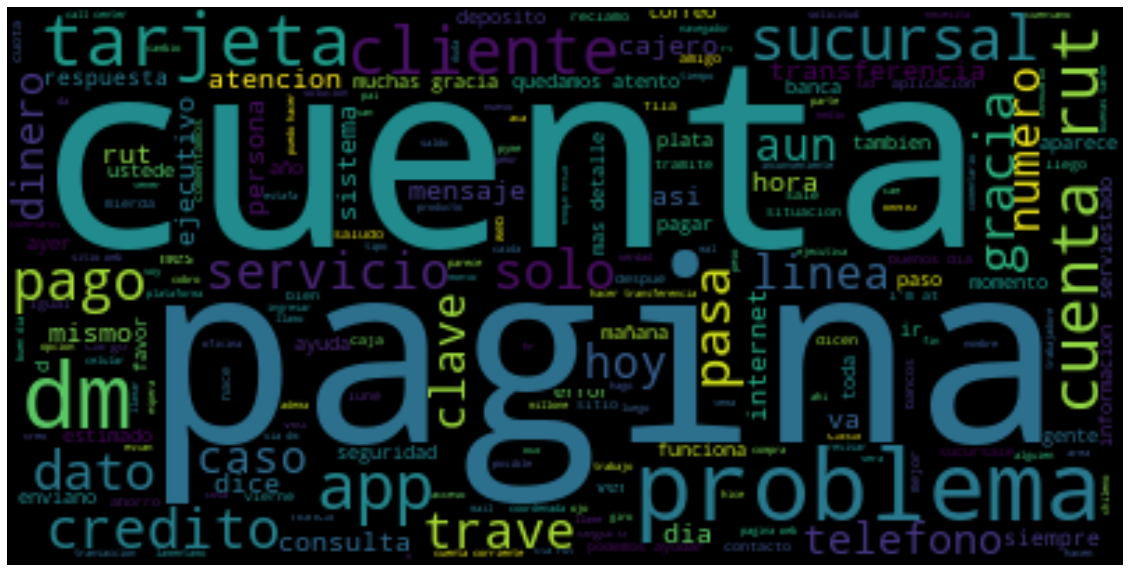

In [8]:
textt = ' '.join( [twts for twts in df['tweet']])
wordcloud = WordCloud(stopwords=stop_words).generate(textt)

plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_base.png')
plt.show()

**Graficas de sentimiento medio por día**

In [6]:
# se realia el sentiment analysis con la libreria sentimentanalysisspanish
# y se añade a una nueva columna
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
df['sentiment'] = df.apply(lambda row : sentiment.sentiment(row['tweet']), axis = 1) 

In [7]:
df.head()

,date,tweet,sentiment
0,2010-01-01,"comienzo 2010 feliz x mi familia, gratitud ban...",0.713020
1,2010-01-03,uf! que mala plataforma bancochile para ctas. ...,0.000033
2,2010-01-04,porque la pag del banco es siempre tan lennnn...,0.054134
3,2010-01-04,"algun lugar recomendable para comprar euros? ,...",0.771148
4,2010-01-04,y es asi como bancochile.cl se va al suelo cua...,0.000132


In [9]:
fechas = df['date'].unique() # recorridas en sentido contrario a volumen!
volumen = df.groupby("date").size().values
data = pd.DataFrame({'date': fechas, 'volumen':volumen})
data.head()

,date,volumen
0,2010-01-01,1
1,2010-01-03,1
2,2010-01-04,22
3,2010-01-05,16
4,2010-01-06,12


In [17]:
# agregamos sentimiento medi y se diario
#data['s_mean'] = 
data['s_mean'] = df.groupby('date').mean().values
data['s_se'] = df.groupby('date').std().values
data.head()

,date,volumen,s_mean,s_se
0,2010-01-01,1,0.713020,NaN
1,2010-01-03,1,0.000033,NaN
2,2010-01-04,22,0.093574,0.180971
3,2010-01-05,16,0.095743,0.176369
4,2010-01-06,12,0.174726,0.242904


In [18]:
data['text'] = ''
for i in range(fechas.size):
    aux = df[df['date'] == fechas[i]]['tweet']
    data['text'][i] = ' '.join( [twts for twts in aux])
    
data['clean_txt'] = ''
for i in range(fechas.size): 
    text = data['text'][i]
    clean = [word for word in word_tokenize(text) if word not in stop_words]
    clean_text = ' '.join(clean)
    data['clean_txt'][i] = clean_text

<ipython-input-18-0966a31945a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'][i] = ' '.join( [twts for twts in aux])
<ipython-input-18-0966a31945a3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_txt'][i] = clean_text


In [19]:
data['sentiment'] = data.apply(lambda row : sentiment.sentiment(row['clean_txt']), axis = 1) 
data['sentiment_raw'] = data.apply(lambda row : sentiment.sentiment(row['text']), axis = 1)

In [21]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data

,volumen,s_mean,s_se,text,clean_txt,sentiment,sentiment_raw
date,,,,,,,
2010-01-01,1,0.713020,NaN,"comienzo 2010 feliz x mi familia, gratitud ban...",comienzo 2010 feliz x familia gratitud cestas ...,8.702934e-01,7.130203e-01
2010-01-03,1,0.000033,NaN,uf! que mala plataforma bancochile para ctas. ...,uf ! mala plataforma ctas empresas cae cada 60...,1.438455e-03,3.317022e-05
2010-01-04,22,0.093574,0.180971,porque la pag del banco es siempre tan lennnn...,pag siempre tan lennnnnnnnnnnnnnnnnnnnta algun...,2.078406e-21,7.768640e-55
2010-01-05,16,0.095743,0.176369,"¿que le pasa a la web de ?!¡ siiiiiiiiiiii, ll...",¿que pasa web ! ¡ siiiiiiiiiiii llevo horas tr...,5.970190e-12,1.545167e-28
2010-01-06,12,0.174726,0.242904,ven por tu hipotecario y se parte de la hincha...,ven hipotecario parte hinchada mundial hoy pod...,5.569822e-10,2.971981e-24
...,...,...,...,...,...,...,...
2021-03-18,633,0.063690,0.154718,que se joda bancoestado patriotas ayudenme a d...,joda patriotas ayudenme difundir denuncia huel...,0.000000e+00,0.000000e+00
2021-03-19,623,0.067762,0.147760,hola daniela ¿te arroja algun mensaje de error...,daniela ¿te arroja algun mensaje error ¿quiere...,0.000000e+00,0.000000e+00
2021-03-20,297,0.073350,0.169509,hola! queria saber si el dia lunes estara abie...,! queria saber dia lunes estara abierta sucurs...,0.000000e+00,0.000000e+00


In [53]:
data.iloc[:,1]

date
2010-01-01    0.713020
2010-01-03    0.000033
2010-01-04    0.093574
2010-01-05    0.095743
2010-01-06    0.174726
                ...   
2021-03-18    0.063690
2021-03-19    0.067762
2021-03-20    0.073350
2021-03-21    0.066059
2021-03-22    0.066554
Name: s_mean, Length: 4094, dtype: float64

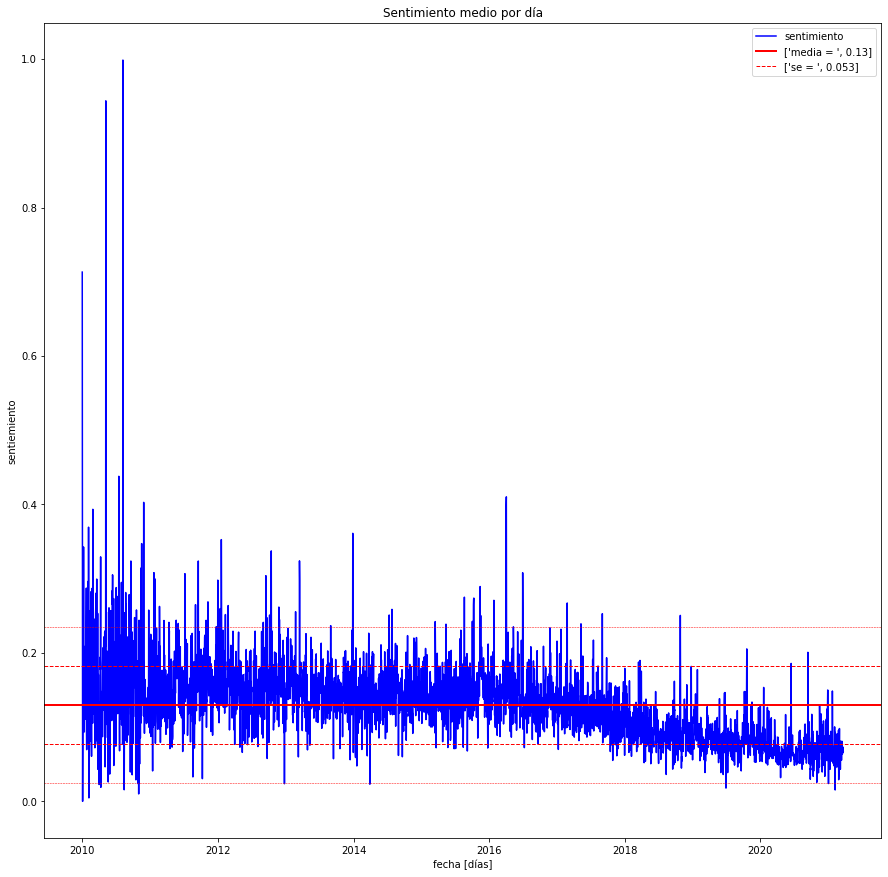

In [50]:
plt.figure(figsize=(15, 15))
plt.plot(data.iloc[:,1],'b')
plt.axhline(data.iloc[:,1].mean(), linewidth=2, color='r',linestyle='-')
plt.axhline(data.iloc[:,1].mean() + data.iloc[:,1].std(), linewidth=1, color='r',linestyle='--')
plt.axhline(data.iloc[:,1].mean() - data.iloc[:,1].std(), linewidth=1, color='r',linestyle='--')
plt.axhline(data.iloc[:,1].mean() + 2*data.iloc[:,1].std(), linewidth=0.5, color='r',linestyle='--')
plt.axhline(data.iloc[:,1].mean() - 2*data.iloc[:,1].std(), linewidth=0.5, color='r',linestyle='--')
plt.legend(['sentimiento', ['media = ' ,round(data.iloc[:,1].mean(),3)], ['se = ',round(data.iloc[:,1].std(),3)]])
plt.title('Sentimiento medio por día',)
plt.xlabel('fecha [días]')
plt.ylabel('sentiemiento')
plt.show()

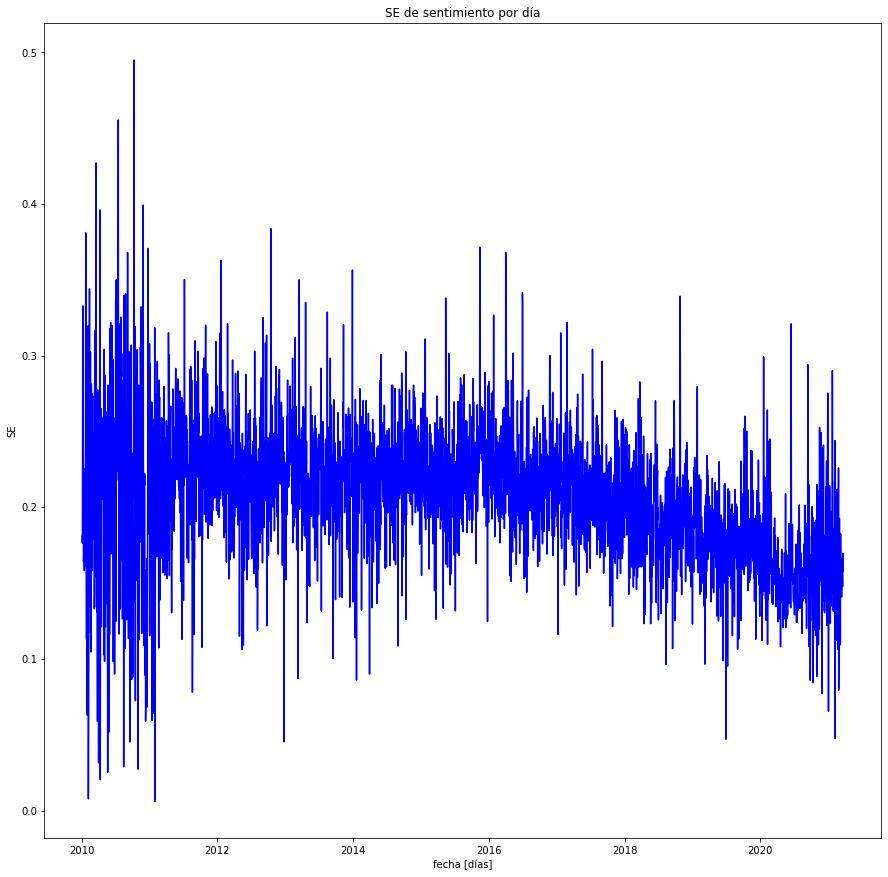

In [51]:
plt.figure(figsize=(15, 15))
plt.plot(data.iloc[:,2],'b')
plt.title('SE de sentimiento por día',)
plt.xlabel('fecha [días]')
plt.ylabel('SE')
plt.show()

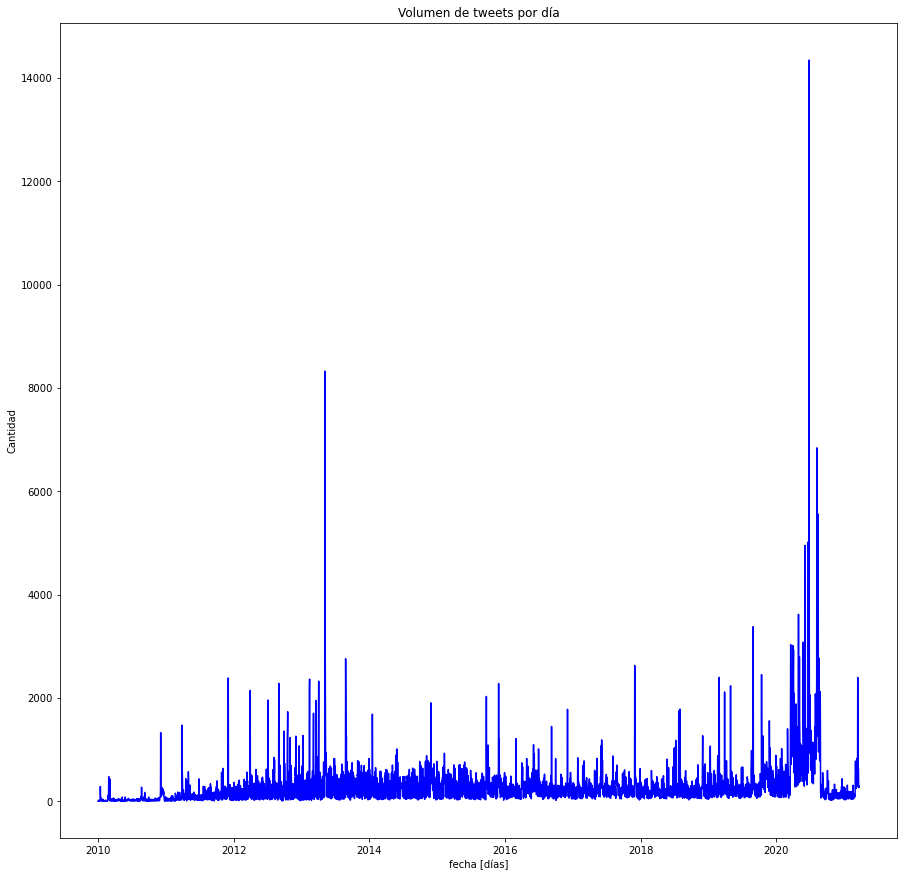

In [55]:
plt.figure(figsize=(15, 15))
plt.plot(data.iloc[:,0],'b')
plt.title('Volumen de tweets por día')
plt.xlabel('fecha [días]')
plt.ylabel('Cantidad')
plt.show()

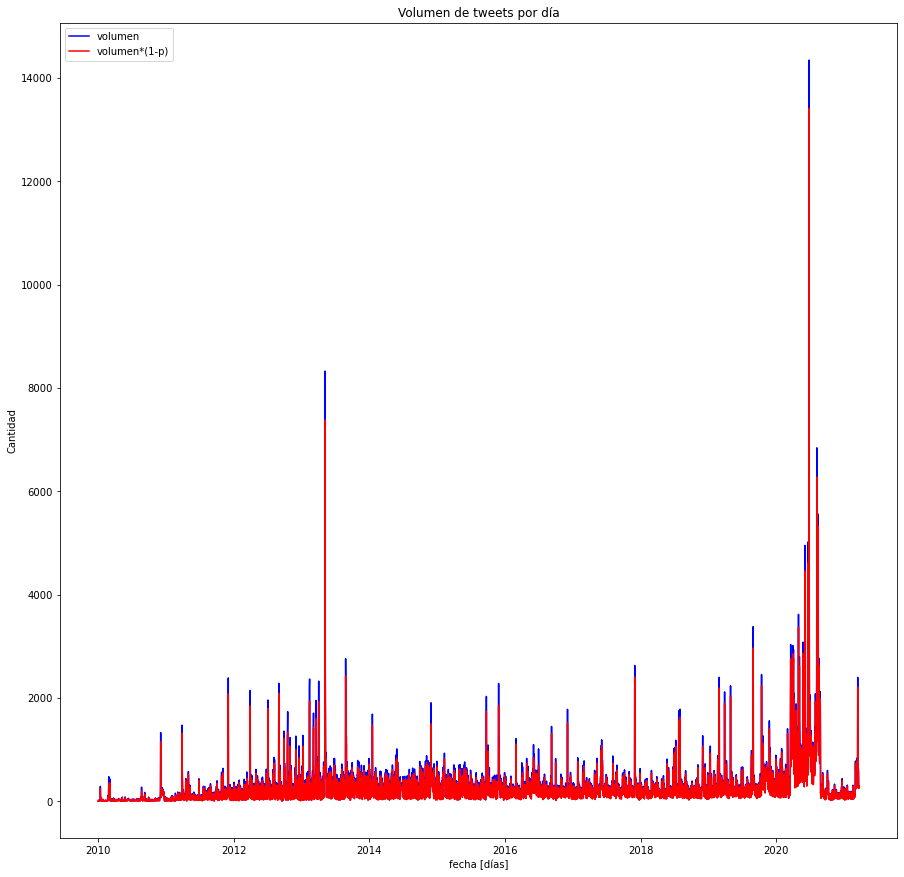

In [58]:
# graficamos volumen junto con volumen*(1-p) para sentimiento medio y total diario
plt.figure(figsize=(15, 15))
plt.plot(data.iloc[:,0],'b')
plt.plot(data.iloc[:,0]*(1-data.iloc[:,1]),'r') # medio diario
plt.legend(['volumen','volumen*(1-p)'])
plt.title('Volumen de tweets por día')
plt.xlabel('fecha [días]')
plt.ylabel('Cantidad')
plt.show()

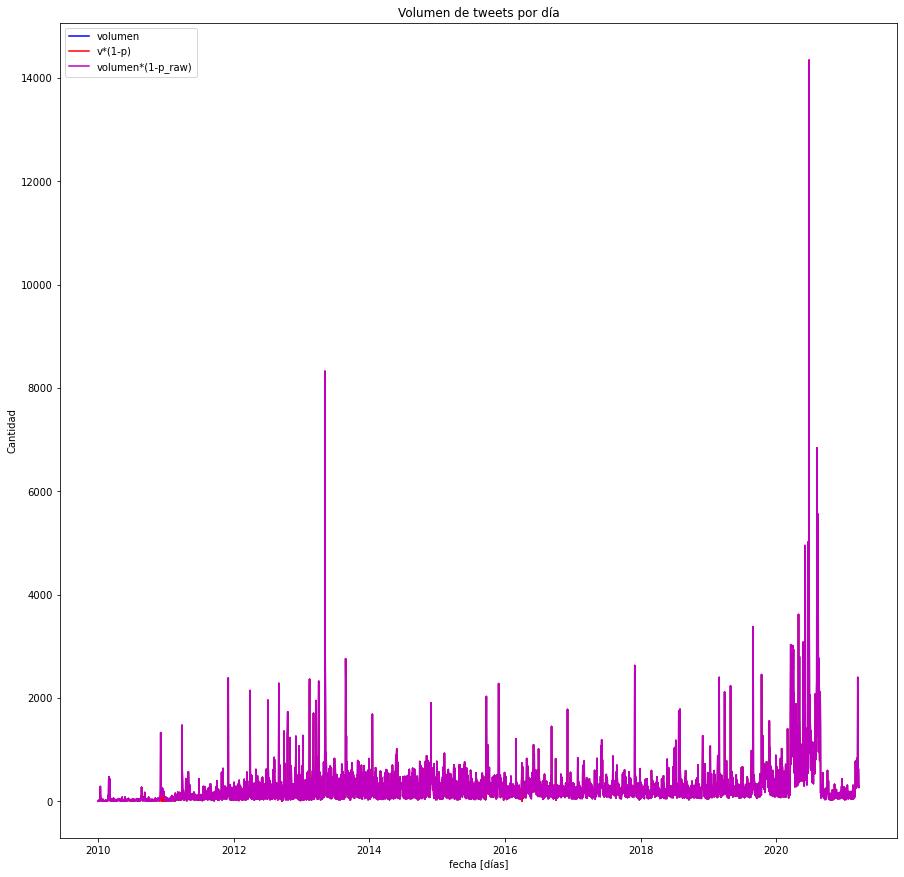

In [61]:
plt.figure(figsize=(15, 15))
plt.plot(data.iloc[:,0],'b')
plt.plot(data.iloc[:,0]*(1-data.iloc[:,5]),'r') # medio diario
plt.plot(data.iloc[:,0]*(1-data.iloc[:,6]),'m') # medio diario
plt.legend(['volumen','v*(1-p)','volumen*(1-p_raw)'])
plt.title('Volumen de tweets por día')
plt.xlabel('fecha [días]')
plt.ylabel('Cantidad')
plt.show()

In [65]:
# calculando la media móvil de a 1 mes: utilizando volumen
data['SMA'] = data.iloc[:,0].rolling(window=30).mean()
data['SMA_SE'] = data.iloc[:,0].rolling(window=30).std()

In [66]:
data

,volumen,s_mean,s_se,text,clean_txt,sentiment,sentiment_raw,SMA,SMA_SE
date,,,,,,,,,
2010-01-01,1,0.713020,NaN,"comienzo 2010 feliz x mi familia, gratitud ban...",comienzo 2010 feliz x familia gratitud cestas ...,8.702934e-01,7.130203e-01,NaN,NaN
2010-01-03,1,0.000033,NaN,uf! que mala plataforma bancochile para ctas. ...,uf ! mala plataforma ctas empresas cae cada 60...,1.438455e-03,3.317022e-05,NaN,NaN
2010-01-04,22,0.093574,0.180971,porque la pag del banco es siempre tan lennnn...,pag siempre tan lennnnnnnnnnnnnnnnnnnnta algun...,2.078406e-21,7.768640e-55,NaN,NaN
2010-01-05,16,0.095743,0.176369,"¿que le pasa a la web de ?!¡ siiiiiiiiiiii, ll...",¿que pasa web ! ¡ siiiiiiiiiiii llevo horas tr...,5.970190e-12,1.545167e-28,NaN,NaN
2010-01-06,12,0.174726,0.242904,ven por tu hipotecario y se parte de la hincha...,ven hipotecario parte hinchada mundial hoy pod...,5.569822e-10,2.971981e-24,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-03-18,633,0.063690,0.154718,que se joda bancoestado patriotas ayudenme a d...,joda patriotas ayudenme difundir denuncia huel...,0.000000e+00,0.000000e+00,450.700000,454.436836
2021-03-19,623,0.067762,0.147760,hola daniela ¿te arroja algun mensaje de error...,daniela ¿te arroja algun mensaje error ¿quiere...,0.000000e+00,0.000000e+00,466.733333,451.646485
2021-03-20,297,0.073350,0.169509,hola! queria saber si el dia lunes estara abie...,! queria saber dia lunes estara abierta sucurs...,0.000000e+00,0.000000e+00,466.233333,451.831956


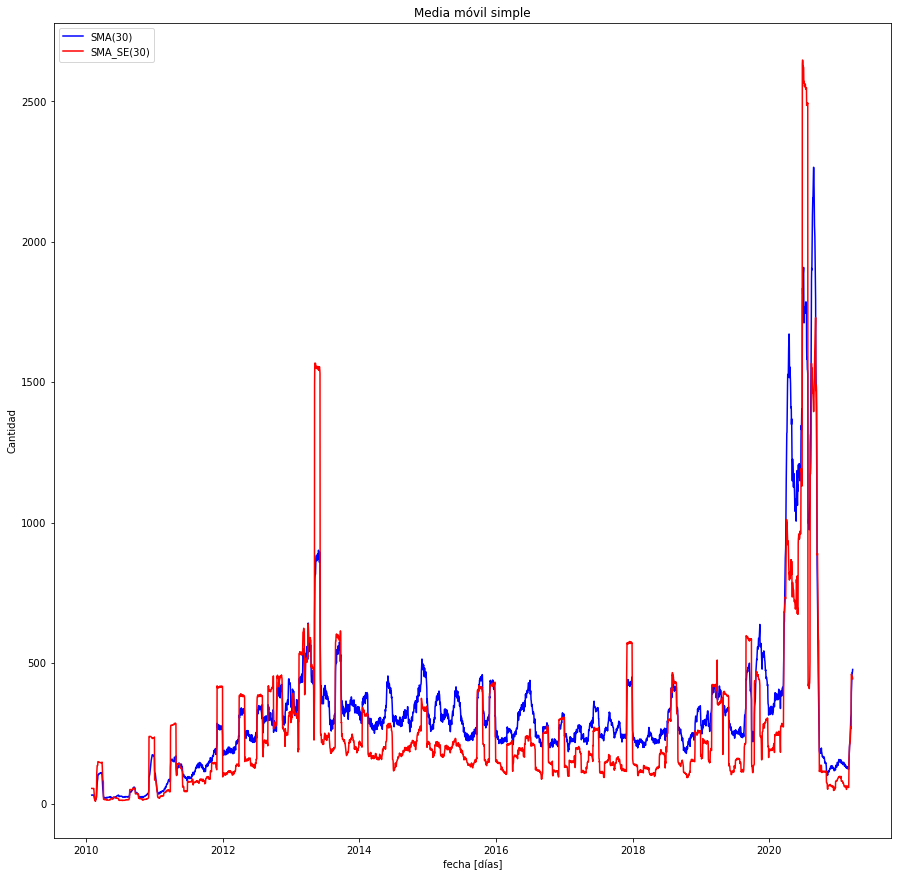

In [67]:
plt.figure(figsize=(15, 15))
plt.plot(data.iloc[:,7],'b')
plt.plot(data.iloc[:,8],'r') # medio diario
plt.legend(['SMA(30)','SMA_SE(30)'])
plt.title('Media móvil simple')
plt.xlabel('fecha [días]')
plt.ylabel('Cantidad')
plt.show()

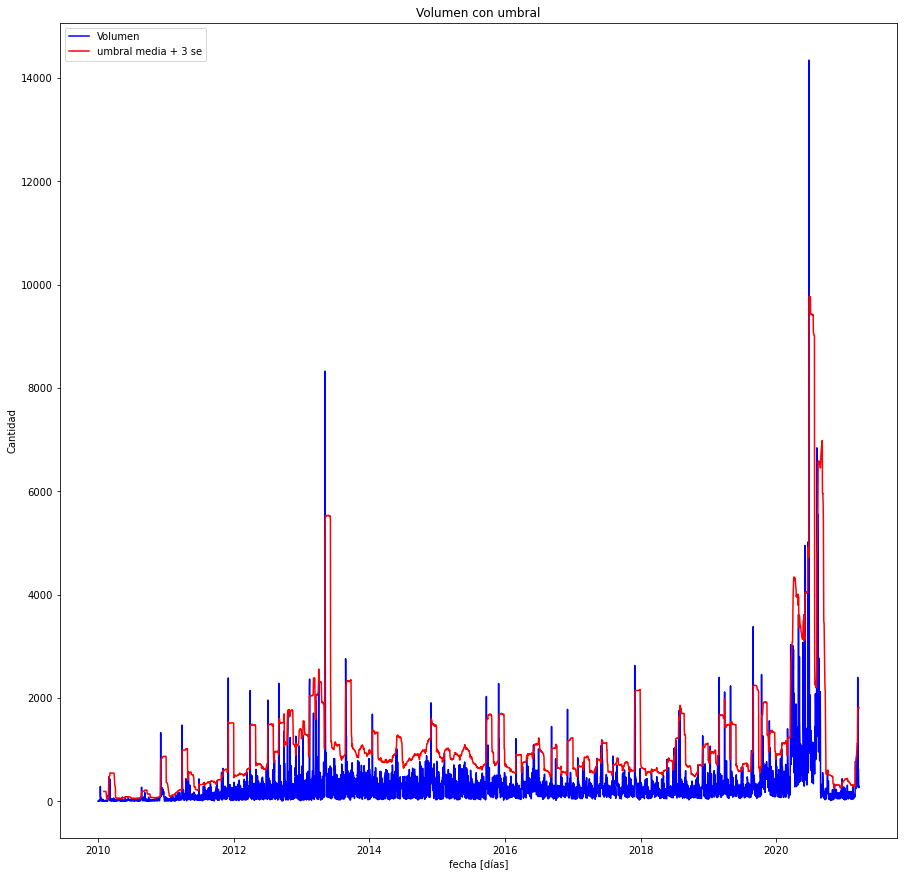

In [70]:
plt.figure(figsize=(15, 15))

plt.plot(data.iloc[:,0],'b')
plt.plot(data.iloc[:,8]*3 + data.iloc[:,7],'r')
plt.legend(['Volumen','umbral media + 3 se'])
plt.title('Volumen con umbral')
plt.xlabel('fecha [días]')
plt.ylabel('Cantidad')
plt.show()

In [71]:
# identificando los peaks
data[data["volumen"] >= data['SMA'] + data['SMA_SE']*3]

,volumen,s_mean,s_se,text,clean_txt,sentiment,sentiment_raw,SMA,SMA_SE
date,,,,,,,,,
2010-02-22,74,0.286844,0.281153,lo mejor es el comercial del pato del banco es...,mejor comercial americo .......... morir siemp...,6.916920e-05,1.210146e-53,14.633333,13.626757
2010-02-25,121,0.215756,0.218654,rt ahi aparecio al pato de banco estado jajja...,rt ahi aparecio jajjajaja / fijo alguien marke...,1.012856e-31,1.095727e-127,20.033333,24.489946
2010-02-27,420,0.393442,0.219565,rt : rt : cruz roja habilito cuenta corriente ...,rt rt cruz roja habilito cuenta corriente nume...,1.233907e-79,2.956731e-139,35.033333,76.766769
2010-02-28,476,0.257486,0.225281,cuenta corriente de la cruz roja nº 36 28 83 d...,cuenta corriente cruz roja nº 36 28 83 terremo...,9.827563e-178,0.000000e+00,50.433333,111.075521
2010-05-11,83,0.122790,0.193452,bienvenidos cualquier tipo de trabajo en alumi...,bienvenidos cualquier tipo trabajo aluminios v...,1.019795e-89,7.646816e-188,24.933333,16.751600
...,...,...,...,...,...,...,...,...,...
2020-12-21,438,0.095528,0.190704,¡hola! te enviamos dm. ¡que tengas un buen ini...,¡hola ! enviamos dm ¡que buen inicio semana ! ...,0.000000e+00,0.000000e+00,131.533333,79.861835
2021-02-18,312,0.057320,0.134464,"hola, efectivamente esta presentando intermite...",efectivamente presentando intermitencias traba...,0.000000e+00,0.000000e+00,131.266667,60.121104
2021-03-02,669,0.098119,0.192556,en serio? me tiene bloqueado 😆 obvio que cada...,serio bloqueado 😆 obvio cada vengas tirar panf...,0.000000e+00,0.000000e+00,145.200000,114.146730


In [74]:
# buscamos 3 fechas: 
fecha1 = data.loc['2011-03-29']['text']
fecha2 = data.loc['2020-09-07']['text']
fecha3 = data.loc['2021-03-15']['text']

In [76]:
# buscamos las palabras más frecuentes y los wordclouds
######### 2011-03-29  #########
tokens = nltk.word_tokenize(data.loc['2011-03-29']['clean_txt'])
text = nltk.Text(tokens)

tokens_l = [w for w in tokens]
freq = nltk.FreqDist(tokens_l)
print(freq.most_common(30))

[('!', 677), ('estonotienenombre', 442), ('``', 213), ('entn', 180), ('rt', 96), ('mas', 96), ('chilenos', 71), ('ejecutivo', 71), ('gente', 70), ('clientes', 65), ('tvn', 61), ('seguros', 60), ('nombre', 60), ('hoy', 53), ('patito', 47), ('cara', 45), ('ejecutivos', 45), ('credito', 42), ('....', 40), ('mal', 39), ('mañana', 36), ('ver', 35), ('hace', 35), ('d', 35), ('viendo', 34), ('solo', 33), ('seguro', 33), ('raja', 32), ('menos', 32), ('hipotecario', 32)]


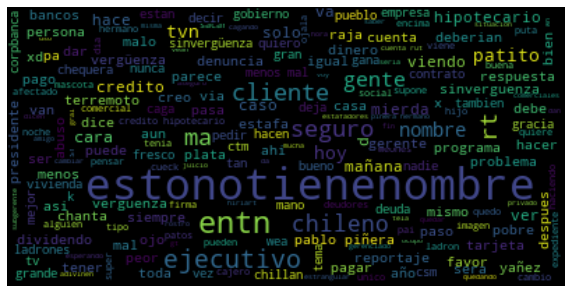

In [77]:
wordcloud = WordCloud(stopwords=stop_words).generate(fecha1)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [78]:
######### 2020-09-07  #########
tokens = nltk.word_tokenize(data.loc['2020-09-07']['clean_txt'])
text = nltk.Text(tokens)

tokens_l = [w for w in tokens]
freq = nltk.FreqDist(tokens_l)
print(freq.most_common(30))

[('!', 217), ('dm', 81), ('favor', 80), ('cuenta', 80), ('¡saludos', 74), ('ayudarte', 63), ('rut', 62), ('mas', 58), ('envianos', 57), ('telefono', 53), ('app', 43), ('``', 42), ('nuevamente', 39), ('ingresar', 38), ('dia', 36), ('hacer', 35), ('dias', 34), ('linea', 33), ('fan', 32), ('disponible', 31), ('sucursal', 30), ('puedo', 29), ('intenta', 29), ('gracias', 28), ('pagina', 28), ('buen', 27), ('acceso', 27), ('clave', 27), ('¡hola', 26), ('poder', 23)]


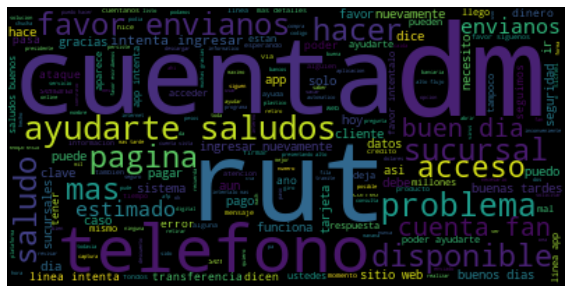

In [81]:
wordcloud = WordCloud(stopwords=stop_words).generate(fecha2)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [82]:
######### 2021-03-15  #########
tokens = nltk.word_tokenize(data.loc['2021-03-15']['clean_txt'])
text = nltk.Text(tokens)

tokens_l = [w for w in tokens]
freq = nltk.FreqDist(tokens_l)
print(freq.most_common(30))

[('!', 876), ('app', 323), ('sistema', 206), ('cuenta', 185), ('pagina', 184), ('problemas', 182), ('puedo', 178), ('pagar', 173), ('mas', 165), ('hacer', 163), ('``', 127), ('pasa', 123), ('puede', 116), ('servicio', 116), ('vez', 115), ('funciona', 112), ('tarjeta', 106), ('mismo', 103), ('siempre', 99), ('rut', 98), ('caida', 95), ('web', 91), ('mensaje', 86), ('problema', 80), ('aplicacion', 78), ('gracias', 76), ('linea', 75), ('transferir', 74), ('solo', 74), ('error', 73)]


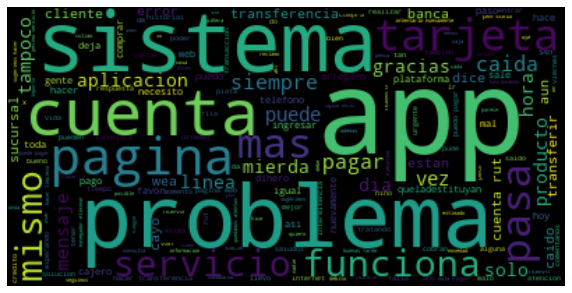

In [83]:
wordcloud = WordCloud(stopwords=stop_words).generate(fecha3)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()